In [126]:
#Latency of image arrival at USDF after shutter close on LSSTCam

In [127]:
# This cell is only for setting parameter defaults
day = "20240925"

In [128]:
from lsst.daf.butler import Butler
from lsst.daf.butler.registry import Registry
import sqlalchemy
from astropy import time


repo = 'embargo_new'
instrument = 'LSSTCam'
dt = 'raw'
# raw all collection contains all images 
collections = [f'{instrument}/raw/all']
butler = Butler(repo, collections=collections, instrument=instrument)
where = f"day_obs={day}"

# Data transferred and ingested in butler and access to data



Get the ingest time for each image in the day

In [129]:
with butler.query() as q:
    q = q.join_dataset_search(dt,collections)
    q = q.where(day_obs=int(day))
    result = list(q.general(["exposure"], "raw.ingest_date", find_first=False))

print (f"Got ingest times for {len(result)} images")


Got ingest times for 280023 images


In [130]:
# Make a map of detectors per exposure for look up below .. its faster than looking up the exposure time for each
# Shutter close is the same for all detector images in the same exposure - so basically grouing. 
dslookup = {}
for ref in result:
   if ref['exposure'] in dslookup:
       exp = dslookup[ref['exposure']] 
   else:  
       exp = {}
       dslookup[ref['exposure']] = exp
   exp[ref['detector']] = ref['raw.ingest_date']

print(f"The images map to {len(dslookup)} exposures.")

The images map to 1366 exposures.


### latency ..
"Measure the delays between completion of readout for each image and the ingestion time recorded in the Butler Registry."
Get the shuter close time for each exposre 
the ID in the dimension record is the exposure ID (dimensionRecord.id)
thed timespan.end is the sutter close time 


In [ ]:
import numpy as np
from astropy.time import Time

shutterTimes = butler.registry.queryDimensionRecords('exposure', where=where, instrument=instrument)
nt = shutterTimes.count()

print (f"Got Metadata (DimensionRecords) for {nt} exposures")


Use the exposure times to work out the time for each imagetransfer  and the max and min for each exposure

In [211]:
times = np.empty(shape = [len(result)]) # time to get to usdf
exptimes = np.empty(shape = [nt]) # shutter close time
expmins  = np.empty(shape = [nt]) # the fastest tranfer
expmaxs  = np.empty(shape = [nt]) # slowes transfer
min = 100
max = 0
tcount = 0


for count, dimensionRecord in enumerate(shutterTimes):
    emin = 100
    emax = 0
    detectorMap = dslookup[dimensionRecord.id]
    prev = dimensionRecord
    for dcount, detector in enumerate(detectorMap): 
        intime = detectorMap[detector]
        # just do some for now too long for noteburst
        diff = (intime - dimensionRecord.timespan.end ).to('minute')
        if diff.value < min:
            min = diff.value
        if diff.value > max:
            max = diff.value 
        if diff.value < emin:
            emin = diff.value
        if diff.value > emax:
            emax = diff.value 
        times[tcount] = (diff.value)
        tcount = tcount+1

    exptimes[count] = dimensionRecord.timespan.end.to_value('mjd')
    expmins[count] = (emin * 60)
    expmaxs[count] = (emax * 60)

print (f"The min time was {min} max time was {max} minutes over {len(times)} times.")
print (f"Time between shutter close and ingest mean:{np.mean(times)}, std:{np.std(times)}, var:{np.var(times)} minutes")

The min time was 0.0728251166666638 max time was 7.634176000000146 minutes over 280023 times.
Time between shutter close and ingest mean:3.376031730398261, std:2.4419662594635767, var:5.963199212358532 minutes


In [208]:
times = [] # time to get to usdf for each image
exptimes = np.empty(shape = [nt]) # shutter close time
expmins  = np.empty(shape = [nt]) # the fastest tranfer
expmaxs  = np.empty(shape = [nt]) # slowes transfer
min = 100.0
max = 0.0

for count, dimensionRecord in enumerate(shutterTimes):
    emin = 100
    emax = 0
    detectorMap = dslookup[dimensionRecord.id]
    prev = dimensionRecord
    thisExpTimes = list(map(lambda dt:(dt - dimensionRecord.timespan.end).to('minute').value,detectorMap.values()))
    last = len(thisExpTimes) -1
    if len(times) == 0:
       times = thisExpTimes
    else:
        times = np.concatenate((times,thisExpTimes))
    if thisExpTimes[0] < min:
        min = thisExpTimes[0]
    if thisExpTimes[last] > max:
        max = thisExpTimes[last] 

    exptimes[count] = dimensionRecord.timespan.end.to_value('mjd')
    expmins[count] = (thisExpTimes[0] * 60)
    expmaxs[count] = (thisExpTimes[last] * 60)

print (f"The min time was {min} max time was {max} minutes over {len(times)} times.")
print (f"Time between shutter close and ingest mean:{np.mean(times)}, std:{np.std(times)}, var:{np.var(times)} minutes")

The min time was 0.0728251166666638 max time was 7.634176000000146 minutes over 280023 times.
Time between shutter close and ingest mean:3.376031730398261, std:2.4419662594635767, var:5.963199212358532 minutes


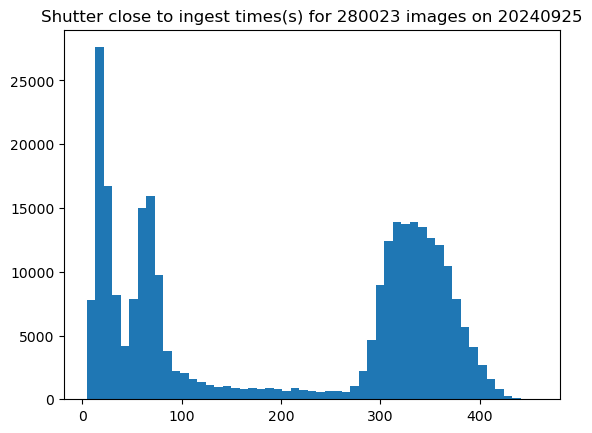

In [209]:
import matplotlib.pyplot as plt
seconds = list(map(lambda t:t*60.0,times))
plt.hist(seconds,bins='auto')
plt.title(f"Shutter close to ingest times(s) for {len(times)} images on {day}")
plt.show()

In [ ]:
## Plot the max and min transfer time for each exposure

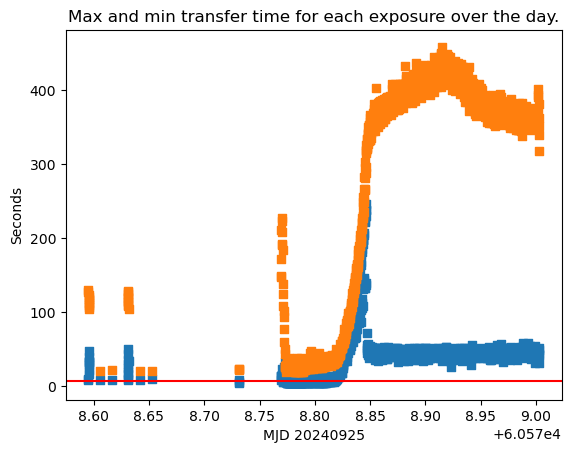

In [176]:

plt.scatter(exptimes, expmins, marker=",")
plt.scatter(exptimes,expmaxs, marker=",")
plt.xlabel(f"MJD {day}")
plt.ylabel("Seconds")
plt.title("Max and min transfer time for each exposure over the day.")
plt.axhline(y = 7, color = 'r', linestyle = '-') 
plt.show()

In [135]:
betweentimes = []
prev = None
for expt in np.sort(exptimes):
    if prev != None:
        betweentimes.append((expt - prev).to('minute'))
    prev = expt
print(f"Got {len(betweentimes)} betweentimes.")
print (f"Time between exposures mean:{np.mean(betweentimes)}, std:{np.std(betweentimes)}, var:{np.var(betweentimes)} minutes")


Got 281388 betweentimes.


TypeError: only dimensionless scalar quantities can be converted to Python scalars

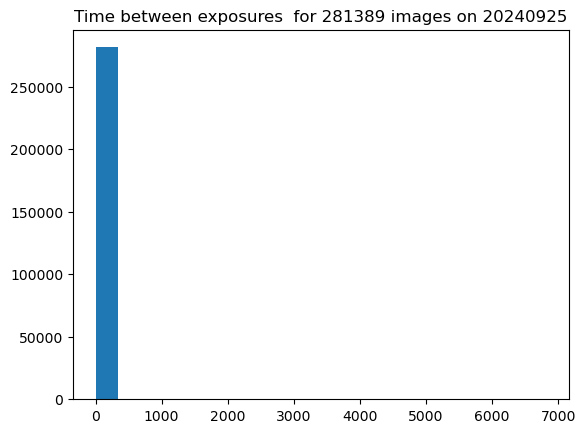

In [134]:
seconds = list(map(lambda t:t*60.0,betweentimes))
plt.hist(seconds,bins='auto')
plt.title(f"Time between exposures  for {len(exptimes)} images on {day}")
plt.show()